# Prueba Científico de Datos Colombina

**Contexto**

Aunque para las compañías es muy importante conseguir nuevos clientes, también es importante retener a sus clientes actuales. Un modelo de predicción de fuga permite a través de los datos recolectados como frecuencia de compras, cantidad de productos comprados, valor de compra, entre otros; anticipar qué clientes pueden continuar o dejar una compañía. Así, realizar cambios proactivos en sus esfuerzos de retención que reducen las tasas de abandono.
Colombina está interesado en saber qué clientes tienen mayor probabilidad de no volver a comprar ninguno de sus productos. **El negocio ha establecido que un cliente que no compra durante 2 meses es un cliente fugado.**

**Task**

Construya un modelo estadístico, Machine Learning o Deep Learning para predecir clientes fugados.

**Variables**

* Doc_vtas : Id de pedido
* Fecha : Fecha del pedido
* Solic :  Código del cliente
* Material : Id del producto solicitado
* Cnt_uni : Cantidad pedida en unidad venta
* sect_mat : código del sector del producto
* Cnt_cart : Cantidad pedidos en unidad cartón
* ValN_Pos : Valor neto en dinero
* Moneda : Moneda

---

### Librerias

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date
import time

from numpy import sqrt
from numpy import argmax
# from matplotlib import pyplot

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

pd.set_option('display.float_format', lambda x: '%.3f' % x)

from sklearn.metrics import roc_curve, mean_squared_error, roc_auc_score, precision_score
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, recall_score
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report, balanced_accuracy_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

### Importando data

In [2]:
df = pd.read_csv('prueba_DS.txt', sep = ',', decimal = '.')
print(df.shape)
df.head()

(12559901, 9)


,Doc_vtas,Fecha,Solic,Material,Cnt_uni,sect_mat,Cnt_cart,ValN_Pos,Moneda
0,7503277849,2021-11-01,18134244,28424,72.000,42,1.000,347.760,COP
1,7503277849,2021-11-01,18134244,26780,6.000,42,6.000,781.400,COP
2,7503277849,2021-11-01,18134244,28846,72.000,42,1.000,309.050,COP
3,7503277849,2021-11-01,18134244,6572,18.000,42,0.375,124.590,COP
4,7503277849,2021-11-01,18134244,28850,1.000,42,1.000,478.870,COP


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12559901 entries, 0 to 12559900
Data columns (total 9 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Doc_vtas  int64  
 1   Fecha     object 
 2   Solic     int64  
 3   Material  int64  
 4   Cnt_uni   float64
 5   sect_mat  int64  
 6   Cnt_cart  float64
 7   ValN_Pos  float64
 8   Moneda    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 862.4+ MB


In [4]:
df.isnull().sum()

Doc_vtas    0
Fecha       0
Solic       0
Material    0
Cnt_uni     0
sect_mat    0
Cnt_cart    0
ValN_Pos    0
Moneda      0
dtype: int64

In [5]:
df.describe()

,Doc_vtas,Solic,Material,Cnt_uni,sect_mat,Cnt_cart,ValN_Pos
count,12559901.000,12559901.000,12559901.000,12559901.000,12559901.000,12559901.000,12559901.000
mean,7504469914.892,6790095.341,23097.064,3.445,44.194,1.093,89.994
std,678732.912,8030957.486,18086.016,334.389,18.315,334.222,583.025
min,7503277849.000,49128.000,294.000,0.000,30.000,0.000,0.000
25%,7503888525.000,1130028.000,6576.000,1.000,30.000,0.056,40.870
50%,7504469273.000,1398056.000,24746.000,1.000,36.000,0.083,54.020
75%,7505060715.000,18056446.000,28854.000,3.000,60.000,0.125,85.600
max,7505636065.000,18179668.000,60964.000,200000.000,261.000,200000.000,1242855.910


In [6]:
df.describe(include = 'O' )

,Fecha,Moneda
count,12559901,12559901
unique,257,1
top,2022-01-11,COP
freq,74801,12559901


In [7]:
print(df['Solic'].nunique()) # Numero de clientes
df['Solic'].value_counts() # cantidad de repeticiones por cliente

80294


18105858    2546
1201000     2468
18110080    2453
164790      2266
1308308     2171
            ... 
1432522        1
1447412        1
1228674        1
18157870       1
18046370       1
Name: Solic, Length: 80294, dtype: int64

* En esta primera inspección de los datos podemos identificar algunos aspectos de calidad de datos importantes a tener en cuenta, como lo son, tipos de datos (importante que coincidan con la naturaleza de la variable), presencia de NA´s o valores nulos, una breve descripción de las variables numéricas y categóricas y por último un breve acercamiento con la cantidad de clientes presentes en la base.


* El análisis se debe enfocar a nivel de cliente, por lo tanto, será necesario transformar la data de manera que se pueda resumir la información a nivel de cliente, ya que se puede observar múltiples registros por código de cliente.


* Es necesario evaluar la cantidad de transacciones o pedidos por fecha, con el fin de identificar aquellos clientes que no compran hace dos meses (fugas) y poder guiar el análisis hacia los clientes que se consideren como fugas o no fugas.


### casteo de variables

In [8]:
print(df['Fecha'].nunique()) 
df['Fecha'].value_counts()

257


2022-01-11    74801
2022-01-12    73001
2022-07-07    72203
2022-06-06    70555
2022-06-07    70329
              ...  
2021-11-07      809
2021-12-25      654
2021-11-14      469
2022-01-01      467
2021-12-31      466
Name: Fecha, Length: 257, dtype: int64

In [9]:
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%Y/%m/%d', errors = 'coerce')

# creo algunas variables, para identificar el dia, el mes y el año de cada pedido, puede que no se use para modelas, 
# pero son muy utiles para realizar validaciones de los calculos de fecha y los distintos fltros que se realicen.

df['dia'] = df['Fecha'].dt.day
df['mes'] = df['Fecha'].dt.month
df['anio'] = df['Fecha'].dt.year

In [10]:
df.head()

,Doc_vtas,Fecha,Solic,Material,Cnt_uni,sect_mat,Cnt_cart,ValN_Pos,Moneda,dia,mes,anio
0,7503277849,2021-11-01,18134244,28424,72.000,42,1.000,347.760,COP,1,11,2021
1,7503277849,2021-11-01,18134244,26780,6.000,42,6.000,781.400,COP,1,11,2021
2,7503277849,2021-11-01,18134244,28846,72.000,42,1.000,309.050,COP,1,11,2021
3,7503277849,2021-11-01,18134244,6572,18.000,42,0.375,124.590,COP,1,11,2021
4,7503277849,2021-11-01,18134244,28850,1.000,42,1.000,478.870,COP,1,11,2021


In [11]:
print('Numero de dias:', df['dia'].nunique())
print('Numero de meses:', df['mes'].nunique())
print('Numero de años:', df['anio'].nunique())

Numero de dias: 31
Numero de meses: 9
Numero de años: 2


In [12]:
df['Fecha'].sort_values(ascending = False) # fecha más actual : 2022-07-15

4826424   2022-07-15
4825083   2022-07-15
4825076   2022-07-15
4825077   2022-07-15
4825078   2022-07-15
             ...    
3885      2021-11-01
3886      2021-11-01
3887      2021-11-01
3888      2021-11-01
0         2021-11-01
Name: Fecha, Length: 12559901, dtype: datetime64[ns]

In [13]:
df['Material'].value_counts()

56236    362536
4382     325710
48514    281827
296      249509
354      217009
          ...  
55310         1
25904         1
25038         1
14172         1
4310          1
Name: Material, Length: 907, dtype: int64

In [14]:
df['sect_mat'].value_counts()  # variable cualitativa, será necesario tratarla para disminuir la cantidad de categorias.

30     4572660
60     2206054
36     1725494
42     1711033
54      731125
48      514810
66      406025
90      152389
51      133782
72       95791
84       88687
108      55622
63       47833
99       42965
114      42347
258      13557
246      11143
111       5387
261       2724
39         351
87         106
255         16
Name: sect_mat, dtype: int64

In [15]:
df['sect_mat'].value_counts(normalize=True).cumsum()

30    0.364
60    0.540
36    0.677
42    0.813
54    0.872
48    0.913
66    0.945
90    0.957
51    0.968
72    0.975
84    0.982
108   0.987
63    0.991
99    0.994
114   0.997
258   0.998
246   0.999
111   1.000
261   1.000
39    1.000
87    1.000
255   1.000
Name: sect_mat, dtype: float64

In [16]:
df['Moneda'].value_counts()  # variable cualitativa, con una sola categoria. No será util para el modelo.

COP    12559901
Name: Moneda, dtype: int64

### featuring eng 

In [17]:
print(df['Doc_vtas'].nunique()) # Numero de pedidos
df['Doc_vtas'].value_counts() # cantidad de repeticiones por pedido

1660725


7505539343    128
7505355465    127
7503688964    119
7504030245    115
7504820865    113
             ... 
7504673699      1
7504717655      1
7504330877      1
7503776035      1
7504592650      1
Name: Doc_vtas, Length: 1660725, dtype: int64

In [18]:
# obeservamos un pedido para entender que siginifican sus repeticiones.

df[df['Doc_vtas']==7505539343] 

,Doc_vtas,Fecha,Solic,Material,Cnt_uni,sect_mat,Cnt_cart,ValN_Pos,Moneda,dia,mes,anio
7635162,7505539343,2022-07-05,1429364,7196,1.000,42,1.000,1162.940,COP,5,7,2022
7635163,7505539343,2022-07-05,1429364,7498,1.000,42,1.000,1077.300,COP,5,7,2022
7635164,7505539343,2022-07-05,1429364,7286,1.000,42,1.000,779.650,COP,5,7,2022
7635165,7505539343,2022-07-05,1429364,13232,1.000,42,1.000,775.870,COP,5,7,2022
7635166,7505539343,2022-07-05,1429364,7954,1.000,42,1.000,722.740,COP,5,7,2022
...,...,...,...,...,...,...,...,...,...,...,...,...
7635285,7505539343,2022-07-05,1429364,54274,1.000,60,0.042,39.310,COP,5,7,2022
7635286,7505539343,2022-07-05,1429364,54336,1.000,60,0.042,36.320,COP,5,7,2022
7635287,7505539343,2022-07-05,1429364,16464,12.000,30,0.083,51.240,COP,5,7,2022
7635288,7505539343,2022-07-05,1429364,60964,1.000,36,0.056,37.890,COP,5,7,2022


In [19]:
df[df['Doc_vtas']==7505539343]['Solic'].value_counts() # el pedido se asocia a un solo cliente

1429364    128
Name: Solic, dtype: int64

In [20]:
df[df['Doc_vtas']==7505539343]['Fecha'].value_counts() # en una sola fecha

2022-07-05    128
Name: Fecha, dtype: int64

In [21]:
df[df['Doc_vtas']==7505539343]['Material'].value_counts() # los pedidos tienen distintos productos

40050    2
25936    2
24976    2
4382     2
54274    2
        ..
7336     1
24746    1
27530    1
27822    1
7424     1
Name: Material, Length: 122, dtype: int64

In [22]:
# A nivel de cliente 

print(df['Solic'].nunique()) # Numero de clientes
df['Solic'].value_counts() # cantidad de repeticiones por cliente

80294


18105858    2546
1201000     2468
18110080    2453
164790      2266
1308308     2171
            ... 
1432522        1
1447412        1
1228674        1
18157870       1
18046370       1
Name: Solic, Length: 80294, dtype: int64

In [23]:
# obeservamos un cliente para entender que siginifican sus repeticiones.

df[df['Solic']==18105858] 

,Doc_vtas,Fecha,Solic,Material,Cnt_uni,sect_mat,Cnt_cart,ValN_Pos,Moneda,dia,mes,anio
13122,7503701727,2021-12-15,18105858,4382,1.000,36,0.062,54.020,COP,15,12,2021
13123,7503701727,2021-12-15,18105858,8254,8.000,48,0.333,553.200,COP,15,12,2021
13124,7503701727,2021-12-15,18105858,8290,4.000,48,0.167,366.160,COP,15,12,2021
13125,7503701727,2021-12-15,18105858,8228,4.000,48,0.250,312.480,COP,15,12,2021
13126,7503701727,2021-12-15,18105858,40182,6.000,60,0.250,163.800,COP,15,12,2021
...,...,...,...,...,...,...,...,...,...,...,...,...
12409140,7505615683,2022-07-13,18105858,6576,9.000,42,0.188,91.930,COP,13,7,2022
12409141,7505615683,2022-07-13,18105858,7954,12.000,42,0.500,361.370,COP,13,7,2022
12409142,7505615683,2022-07-13,18105858,7512,6.000,42,0.250,200.020,COP,13,7,2022
12409143,7505615683,2022-07-13,18105858,13684,6.000,42,0.250,132.080,COP,13,7,2022


In [24]:
df[df['Solic']==18105858]['Doc_vtas'].value_counts() # el cliente tiene multiples pedidos asociados

7505615683    70
7504087951    70
7504355957    62
7503857723    58
7503806948    55
              ..
7504870161     1
7505514268     1
7505422021     1
7503497363     1
7505023038     1
Name: Doc_vtas, Length: 86, dtype: int64

In [25]:
df[df['Solic']==18105858]['Fecha'].value_counts() # en distintas fechas

2022-02-02    70
2022-07-13    70
2022-03-02    62
2022-01-08    58
2021-12-27    55
              ..
2021-12-03     2
2022-04-24     2
2022-02-15     2
2022-04-26     1
2022-02-25     1
Name: Fecha, Length: 74, dtype: int64

In [26]:
df[df['Solic']==18105858]['Material'].value_counts() # los pedidos tienen distintos productos

28852    46
28854    45
40182    44
55384    44
28424    36
         ..
27068     1
27264     1
27274     1
27280     1
12226     1
Name: Material, Length: 247, dtype: int64

Pensando en la construccion de la variable de respuesta, nuestros clientes fugados serán aquellos que no tienen información de compras en los ultimos dos meses a partir de la fecha más actual que encontramos en la base
 

In [27]:
df['Fecha'].max()

Timestamp('2022-07-15 00:00:00')

In [28]:
df[df['Fecha']>'2022-05-15']['mes'].value_counts()

6    1573805
5     820711
7     738216
Name: mes, dtype: int64

In [29]:
df[df['Fecha']<='2022-05-15']['Solic'].value_counts() # clientes sin compras en los ultimos dos meses

18105858    1936
18110080    1849
1201000     1845
164790      1790
1308308     1660
            ... 
1878372        1
1372760        1
18157870       1
1251470        1
18093036       1
Name: Solic, Length: 77013, dtype: int64

Debemos identificar quienes si tienen información hasta la actualidad para excluirlos de los clientes fugados y que su información quede completa y no se pierda en el filtro anterior.

In [30]:
df[df['Fecha']>'2022-05-15']['Solic'].value_counts() 

1390392     750
1201000     623
18105858    610
18112954    609
18110080    604
           ... 
1407950       1
1423976       1
18088304      1
1443686       1
1105248       1
Name: Solic, Length: 69943, dtype: int64

In [31]:
# definimos los clientes que no se fugan, temporalmente.

clientes_nofuga = df[df['Fecha']>'2022-05-15']['Solic'].unique().tolist()
print(len(clientes_nofuga))
clientes_nofuga

69943


[18140972,
 1367944,
 180050,
 18042426,
 173734,
 1456762,
 18035406,
 1446508,
 1265120,
 1024638,
 1212108,
 1429976,
 1282068,
 1450920,
 1302628,
 1242504,
 1067018,
 1396714,
 18126244,
 1313518,
 1386266,
 1243276,
 1450892,
 1457242,
 1087064,
 1067614,
 1270536,
 1154634,
 1398792,
 18160018,
 18164584,
 1063330,
 18169998,
 1332472,
 18073566,
 1309970,
 18149116,
 18024326,
 143656,
 82042,
 1098896,
 1221356,
 18174900,
 1192502,
 1399348,
 1063396,
 1386312,
 18130336,
 1099958,
 1073986,
 1068444,
 145706,
 1109924,
 1426852,
 1329766,
 18119186,
 1003374,
 1448548,
 1110778,
 1229290,
 1372762,
 106308,
 18129402,
 1419972,
 1201238,
 1067352,
 1265888,
 18038610,
 1245330,
 18055764,
 171016,
 18038738,
 1409544,
 18159524,
 18080778,
 187010,
 1293698,
 1393246,
 1404558,
 1071784,
 1121262,
 18056988,
 1454494,
 1242066,
 1137884,
 18174496,
 1100822,
 1203550,
 1036718,
 18083400,
 1109018,
 18109346,
 18148224,
 1223900,
 1428116,
 1333816,
 1064314,
 18022922,
 132

In [32]:
# un clientes que se fuga es un cliente que en los ultimos dos meses no tiene compras. 

clientes_fuga = df[df['Fecha']<='2022-05-15']['Solic'].unique().tolist()
print(len(clientes_fuga))
clientes_fuga

77013


[18134244,
 1421200,
 1418940,
 1350148,
 18050322,
 18132326,
 1365432,
 1441604,
 18135870,
 1177234,
 1246574,
 18051298,
 1087724,
 1092718,
 1383916,
 18056188,
 1086390,
 18056428,
 1092928,
 1299736,
 1363546,
 1449258,
 18118058,
 1455644,
 18123390,
 1407526,
 1089526,
 18056192,
 1357472,
 1442776,
 1404430,
 1437902,
 1371850,
 1092724,
 1430040,
 133074,
 18137346,
 1209708,
 1445244,
 18026218,
 1318246,
 1404426,
 18113992,
 1398434,
 18111766,
 18012284,
 1200348,
 18131492,
 1172488,
 1085134,
 166824,
 131174,
 1366766,
 18135052,
 1085452,
 1086492,
 18111734,
 18059802,
 1449804,
 1268486,
 18021324,
 18106398,
 18067508,
 1081568,
 18052848,
 1122974,
 18033170,
 18022364,
 1264154,
 1331152,
 18061246,
 1383634,
 1089000,
 18011666,
 1455648,
 1272490,
 18055408,
 18046360,
 1403978,
 1408370,
 1234110,
 1092828,
 18052442,
 1420194,
 18121440,
 1147124,
 1242310,
 1455646,
 18134246,
 1400090,
 18012418,
 1407694,
 1387144,
 1446450,
 1407520,
 1944728,
 18097684,

In [33]:
df_fuga = df[df['Solic'].isin(clientes_fuga)]
df_fuga = df[~df['Solic'].isin(clientes_nofuga)]

df_fuga.shape

(440705, 12)

In [34]:
clientes_fuga = df_fuga['Solic'].unique().tolist()
len(clientes_fuga)

10351

In [35]:
df_nofuga = df[~df['Solic'].isin(clientes_fuga)]
df_nofuga.shape

(12119196, 12)

Validamos que las bases que creamos no tengan clientes en ambos grupos, y que al unir los dos grupos de clientes (fugados y no jugados) tengamos la misma cantidad de registros y de clientes.

In [36]:
print('clientes totales', df['Solic'].nunique())

print('clientes que no se han fugado', df_nofuga['Solic'].nunique())
print('clientes que se han fugado', df_fuga['Solic'].nunique())


clientes totales 80294
clientes que no se han fugado 69943
clientes que se han fugado 10351


In [37]:
print('registros totales', df.shape)

print('registros que no se han fugado', df_nofuga.shape)
print('registros que se han fugado', df_fuga.shape)


registros totales (12559901, 12)
registros que no se han fugado (12119196, 12)
registros que se han fugado (440705, 12)


Una vez identificados los clientes que se fugan o no, podemos crear la marca para despues agrupar la informacion a nivel de cliente

In [38]:
df_fuga['fuga'] = 1
df_nofuga['fuga'] = 0

df_model = pd.concat([df_fuga, df_nofuga])
df_model.shape

<ipython-input-38-08e4483888f6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fuga['fuga'] = 1
<ipython-input-38-08e4483888f6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nofuga['fuga'] = 0


(12559901, 13)

In [39]:
df_fuga['Fecha'].max() # validamos que los clientes fugados efectivamente  no tengan pedidos en los ultimos dos meses.

Timestamp('2022-05-15 00:00:00')

In [40]:
df_nofuga['Fecha'].min()

Timestamp('2021-11-01 00:00:00')

In [41]:
df_nofuga['Fecha'].max() # y los clientes no fugados, son clientes que hasta la actualidad hacen pedidos.

Timestamp('2022-07-15 00:00:00')

In [42]:
df_model.head()

,Doc_vtas,Fecha,Solic,Material,Cnt_uni,sect_mat,Cnt_cart,ValN_Pos,Moneda,dia,mes,anio,fuga
7,7503277850,2021-11-01,1421200,9388,6.000,60,6.000,4528.800,COP,1,11,2021,1
8,7503277850,2021-11-01,1421200,40302,6.000,60,6.000,2764.800,COP,1,11,2021,1
9,7503277850,2021-11-01,1421200,54932,9.000,60,9.000,4375.080,COP,1,11,2021,1
10,7503277850,2021-11-01,1421200,54810,1.000,60,1.000,1039.920,COP,1,11,2021,1
11,7503277850,2021-11-01,1421200,54812,1.000,60,1.000,1039.920,COP,1,11,2021,1


In [43]:
df_model['fuga'].value_counts(normalize=True)

0   0.965
1   0.035
Name: fuga, dtype: float64

In [44]:
df_model[['Cnt_uni']].describe()

,Cnt_uni
count,12559901.000
mean,3.445
std,334.389
min,0.000
25%,1.000
50%,1.000
75%,3.000
max,200000.000


In [45]:
df_model['anio'] = df_model['anio'].astype(str)
df_model['mes'] = df_model['mes'].astype(str)

df_model['anio_mes'] = df_model['anio'] + '_' + df_model['mes']

In [46]:
df_model[df_model['Cnt_uni']==0].head()

,Doc_vtas,Fecha,Solic,Material,Cnt_uni,sect_mat,Cnt_cart,ValN_Pos,Moneda,dia,mes,anio,fuga,anio_mes
169866,7503350962,2021-11-08,1096012,27014,0.000,84,0.000,0.000,COP,8,11,2021,0,2021_11
1057037,7504035851,2022-01-27,18115352,6486,0.000,42,0.000,0.000,COP,27,1,2022,0,2022_1


In [47]:
df_model[df_model['Solic']==1096012]['Fecha'].max()

Timestamp('2022-07-14 00:00:00')

In [48]:
ventas_cliente_fecha = df_model.groupby(['Solic', 'fuga', 
                                         'sect_mat', 'anio_mes']).agg({'Material' : 'size',
                                                                       'Cnt_uni'  : 'sum',
                                                                       'Cnt_cart' : 'sum',
                                                                       'ValN_Pos' : 'sum'}).reset_index()
print(ventas_cliente_fecha.shape)
ventas_cliente_fecha.head()

(2659505, 8)


,Solic,fuga,sect_mat,anio_mes,Material,Cnt_uni,Cnt_cart,ValN_Pos
0,49128,0,30,2021_11,41,94.000,38.819,11310.770
1,49128,0,30,2021_12,6,11.000,5.400,1495.420
2,49128,0,30,2022_1,29,48.000,29.333,7700.320
3,49128,0,30,2022_2,38,76.000,33.094,9823.440
4,49128,0,30,2022_3,31,65.000,27.667,9099.480


In [49]:
ventas_cliente_fecha['Solic'].value_counts()

1043614     115
18118098    112
1201000     111
18054452    111
18131064    111
           ... 
1443286       1
18174940      1
104658        1
18078166      1
1429946       1
Name: Solic, Length: 80294, dtype: int64

In [50]:
ventas_cliente_fecha['sect_mat'].value_counts(normalize=True).cumsum()

30    0.192
36    0.353
60    0.506
54    0.614
42    0.713
48    0.790
66    0.841
72    0.867
84    0.893
51    0.918
90    0.936
108   0.954
114   0.969
63    0.983
99    0.992
258   0.995
246   0.997
111   0.999
261   1.000
39    1.000
87    1.000
255   1.000
Name: sect_mat, dtype: float64

In [51]:
ventas_cliente_fecha['anio_mes'].value_counts()

2022_3     320960
2022_5     316805
2022_2     306822
2022_6     306792
2021_11    304670
2022_4     301699
2022_1     292993
2021_12    292690
2022_7     216074
Name: anio_mes, dtype: int64

In [52]:
df['Material'].value_counts()

56236    362536
4382     325710
48514    281827
296      249509
354      217009
          ...  
55310         1
25904         1
25038         1
14172         1
4310          1
Name: Material, Length: 907, dtype: int64

In [53]:
ventas_cliente_fecha[ventas_cliente_fecha['Solic']==1043614]

,Solic,fuga,sect_mat,anio_mes,Material,Cnt_uni,Cnt_cart,ValN_Pos
395048,1043614,0,30,2021_11,57,220.000,12.578,4306.940
395049,1043614,0,30,2021_12,68,321.000,14.517,4467.440
395050,1043614,0,30,2022_1,70,412.000,21.246,5457.650
395051,1043614,0,30,2022_2,42,183.000,7.575,2667.710
395052,1043614,0,30,2022_3,86,404.000,17.121,5474.360
...,...,...,...,...,...,...,...,...
395158,1043614,0,108,2022_5,1,3.000,0.120,0.030
395159,1043614,0,108,2022_6,2,12.000,0.480,0.120
395160,1043614,0,114,2021_12,1,10.000,10.000,2436.800
395161,1043614,0,114,2022_6,1,1.000,1.000,631.030


In [54]:
ventas_cliente_fecha[ventas_cliente_fecha['Solic']==1043614]['fuga'].value_counts()

0    115
Name: fuga, dtype: int64

In [55]:
ventas_cliente_fecha[ventas_cliente_fecha['Solic']==1043614]['Material'].value_counts()

1     19
2     15
3     12
4      9
5      7
6      6
8      3
12     3
49     2
72     2
22     2
13     2
25     2
57     2
7      2
11     1
23     1
9      1
15     1
17     1
18     1
20     1
10     1
86     1
27     1
37     1
70     1
68     1
62     1
61     1
60     1
58     1
56     1
54     1
53     1
50     1
47     1
45     1
44     1
42     1
40     1
26     1
Name: Material, dtype: int64

se quiere ver si la cantidad de pedidos vendidos por mes tiene algun patron de comportamiento entre las fugas y no fugas, esto nos dara una idea de la influencia de la temporalidad en que un cliente se fuge o no.

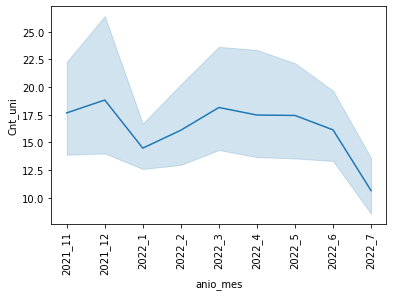

In [56]:
sns.lineplot(x = 'anio_mes', y = 'Cnt_uni', data = ventas_cliente_fecha[ventas_cliente_fecha['fuga']==0])
_ = plt.xticks(rotation = 90)

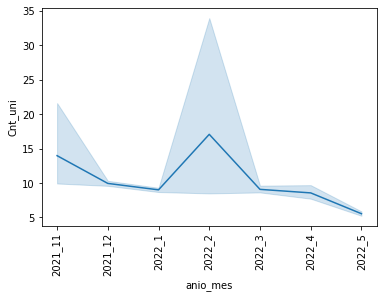

In [57]:
sns.lineplot(x = 'anio_mes', y = 'Cnt_uni', data = ventas_cliente_fecha[ventas_cliente_fecha['fuga']==1])
_ = plt.xticks(rotation = 90)

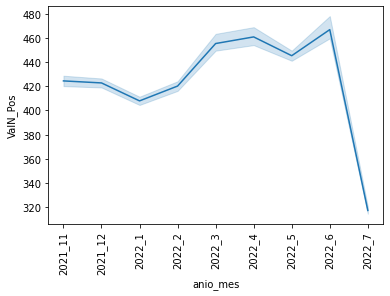

In [58]:
sns.lineplot(x = 'anio_mes', y = 'ValN_Pos', data = ventas_cliente_fecha[ventas_cliente_fecha['fuga']==0])
_ = plt.xticks(rotation = 90)

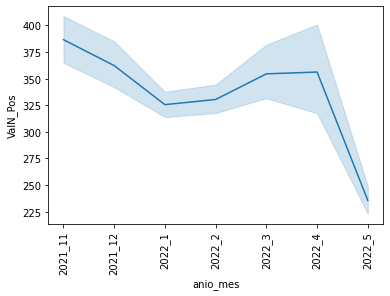

In [59]:
sns.lineplot(x = 'anio_mes', y = 'ValN_Pos', data = ventas_cliente_fecha[ventas_cliente_fecha['fuga']==1])
_ = plt.xticks(rotation = 90)

Estos graficos nos muestra la relacion entre la cantidad pedida por unidad de venta, el valor neto contra los nueve meses de información disponible, en cada caso vemos la diferencia en los clientes fugados y no fugados. 

En ambos casos vemos que las series de tiempo nos muestran comportamientos similares, claramente con valores menores en los clientes fugados, pero esto puede ser por que los clientes fugados son menos cantidad que los no fugados, no necesaramiente por una disminucion en las compras.

Ahora probaremos como se comportan las ventas a nivel de cliente y por materiales.

In [60]:
ventas_cliente = df_model.groupby(['Solic', 'fuga', 'Material']).agg({
                                                           'Cnt_uni'  : 'sum',
                                                           'Cnt_cart' : 'sum',
                                                           'ValN_Pos' : 'sum'}).reset_index()
print(ventas_cliente.shape)
ventas_cliente.head()

(4288142, 6)


,Solic,fuga,Material,Cnt_uni,Cnt_cart,ValN_Pos
0,49128,0,296,1.000,0.056,37.840
1,49128,0,354,9.000,0.500,451.770
2,49128,0,436,1.000,0.056,60.240
3,49128,0,1246,50.000,2.778,2709.770
4,49128,0,2458,1.000,0.062,41.030


In [61]:
ventas_cliente['Material'].value_counts(normalize=True).cumsum().reset_index().head(10)

,index,Material
0,56236,0.016
1,4382,0.031
2,296,0.045
3,48514,0.059
4,354,0.073
5,54274,0.085
6,15988,0.097
7,25936,0.108
8,24746,0.119
9,15310,0.130


Suena interesante analizar como influye el tipo de producto solicitado (Material) pero por cuestiones de tiempo, esta variable no se profundizara ya que son muchos productos distintos y no hay un top diez notable para realizar algun filtro o enfoque.

Se puede pensar que si los clientes fugados disminuyen la compra de algunos productos en especial, esto nos podria determinar algun tipo de patron que permita identificar oportunamente el cliente que se fuga.

In [62]:
ventas_cliente_sector = df_model.groupby(['Solic', 'fuga', 'sect_mat']).agg({
                                                           'Cnt_uni'  : 'mean',
                                                           'Cnt_cart' : 'mean',
                                                           'ValN_Pos' : 'mean'}).reset_index()
print(ventas_cliente_sector.shape)
ventas_cliente_sector.head()

(640391, 6)


,Solic,fuga,sect_mat,Cnt_uni,Cnt_cart,ValN_Pos
0,49128,0,30,1.985,1.030,311.624
1,49128,0,36,5.609,0.386,326.787
2,49128,0,48,11.489,0.378,618.300
3,49128,0,60,12.133,0.352,222.440
4,49128,0,66,3.041,0.166,157.802


In [63]:
print(ventas_cliente_sector['sect_mat'].nunique())

ventas_cliente_sector['sect_mat'].value_counts(normalize = True).cumsum()

22


30    0.122
36    0.239
60    0.355
54    0.450
42    0.538
48    0.617
66    0.672
114   0.725
51    0.775
84    0.824
108   0.869
63    0.904
72    0.936
90    0.962
99    0.978
258   0.986
246   0.993
111   0.997
261   1.000
39    1.000
87    1.000
255   1.000
Name: sect_mat, dtype: float64

In [64]:
pd.crosstab(ventas_cliente_sector['sect_mat'],ventas_cliente_sector['fuga'], normalize=True)

fuga,0,1
sect_mat,,
30,0.108,0.014
36,0.104,0.012
39,0.000,0.000
42,0.081,0.007
48,0.073,0.006
51,0.046,0.003
54,0.086,0.009
60,0.104,0.012
63,0.033,0.002


In [65]:
ventas_cliente_sector.groupby(['sect_mat'])['fuga'].sum().reset_index()

,sect_mat,fuga
0,30,9192
1,36,7826
2,39,8
3,42,4729
4,48,3881
5,51,1974
6,54,5633
7,60,7804
8,63,1243
9,66,3008


Existen 22 sectores de productos distintos, puede ser interesante analizar si la disminucion o aumento de compras por sector varia o si existe algún patron entre el cambio de un sector a otro, para probar la hipotesis de que esta variable representa algun cambio entre los clientes fugados y no fugados. Por cuestiones de tiempo, no analizaremos el impacto de los sectores pero es una variable que puede ser muy interesante analizarla.


El estudio esta enfocado en la fugas a nivel de cliente, por lo tanto agruparemos la información por Solic (codigo de cliente) y traeremos el promedio de la cantidad pedida en unidad de venta, cantidad de pedidos en unidad de carton y el valor neto en dinero para cada cliente

In [66]:
ventas_cliente = df_model.groupby(['Solic', 'fuga']).agg({
                                                           'Cnt_uni'  : 'mean',
                                                           'Cnt_cart' : 'mean',
                                                           'ValN_Pos' : 'mean'}).reset_index()
print(ventas_cliente.shape)
ventas_cliente.head()

(80294, 5)


,Solic,fuga,Cnt_uni,Cnt_cart,ValN_Pos
0,49128,0,4.931,0.693,304.072
1,69792,0,2.579,0.108,66.117
2,69838,0,6.824,0.317,138.823
3,69868,0,3.247,0.109,74.253
4,70334,0,2.149,0.193,136.520


In [67]:
ventas_cliente['fuga'].value_counts(normalize=True)

0   0.871
1   0.129
Name: fuga, dtype: float64

In [68]:
ventas_cliente['fuga'].value_counts()

0    69943
1    10351
Name: fuga, dtype: int64

Podemos ver que el porcentaje de clientes fugados es del 13% y de no fugados del 87% por lo que estamos frente a una base desbalanceada, esto puede representar problemas en el entrenamiento de modelos, pero existen tecnicas como el undersampling o el oversampling que pueden ayudar a balancear la base y disminuir un posible problema de que el modelo entienda unicamente la clase mayoritaria que en este caso son los clientes no fugados.

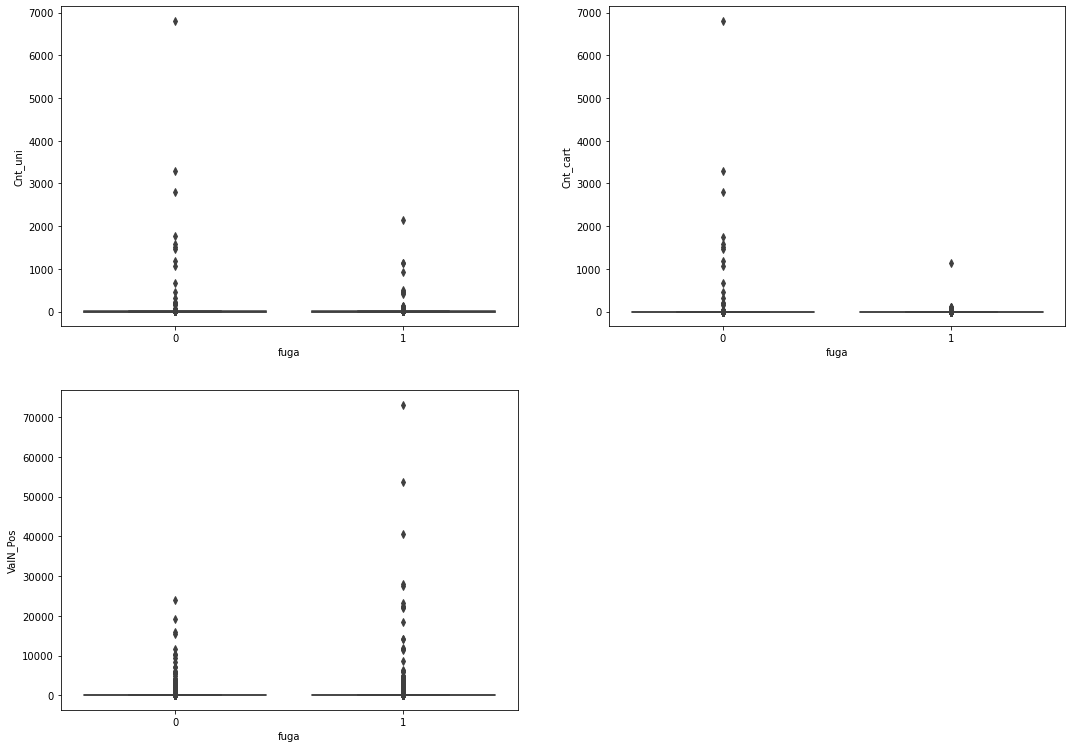

In [69]:
cols = ['Cnt_uni', 'Cnt_cart', 'ValN_Pos']
i=1
plt.figure(figsize=(18,20))
for col in cols:
    plt.subplot(3,2,i)
    sns.boxplot(x='fuga',y=col,data=ventas_cliente)
    i += 1

In [70]:
ventas_cliente.describe()

,Solic,fuga,Cnt_uni,Cnt_cart,ValN_Pos
count,80294.000,80294.000,80294.000,80294.000,80294.000
mean,7769535.707,0.129,2.618,0.462,94.406
std,8320797.821,0.335,33.077,31.503,472.252
min,49128.000,0.000,1.000,0.019,17.674
25%,1176133.000,0.000,1.357,0.089,58.280
50%,1421824.000,0.000,1.780,0.111,68.529
75%,18087503.000,0.000,2.553,0.144,85.517
max,18179668.000,1.000,6806.290,6804.876,73157.360


In [71]:
ventas_cliente[ventas_cliente['Cnt_uni']>1000]

,Solic,fuga,Cnt_uni,Cnt_cart,ValN_Pos
4511,148622,0,1195.316,1193.003,93.701
4763,151048,0,6806.290,6804.876,126.114
9453,1023144,0,3301.352,3297.033,290.015
18730,1142450,1,1130.005,1127.075,679.828
18761,1143152,1,1140.000,95.000,40568.040
23907,1241780,0,1591.791,1587.725,193.043
26079,1274790,0,1461.954,1458.640,228.161
26605,1282022,0,2792.861,2790.009,106.040
39244,1416442,0,1508.797,1503.996,186.677
39811,1419784,0,1070.822,1065.703,120.491


In [72]:
df[df['Solic']==151048]

,Doc_vtas,Fecha,Solic,Material,Cnt_uni,sect_mat,Cnt_cart,ValN_Pos,Moneda,dia,mes,anio
65098,7503786251,2021-12-22,151048,27060,200000.000,87,200000.000,1920.000,COP,22,12,2021
74350,7503787650,2021-12-23,151048,11774,2.000,42,0.042,18.820,COP,23,12,2021
74351,7503787650,2021-12-23,151048,26938,1.000,54,1.000,73.470,COP,23,12,2021
74352,7503787650,2021-12-23,151048,6576,6.000,42,0.125,64.260,COP,23,12,2021
74353,7503787650,2021-12-23,151048,15498,1.000,54,0.056,42.450,COP,23,12,2021
...,...,...,...,...,...,...,...,...,...,...,...,...
12517302,7504710803,2022-04-07,151048,296,1.000,30,0.056,38.010,COP,7,4,2022
12517303,7504710803,2022-04-07,151048,27296,1.000,30,1.000,85.490,COP,7,4,2022
12517304,7504710803,2022-04-07,151048,24956,1.000,30,0.056,35.170,COP,7,4,2022
12517305,7504710803,2022-04-07,151048,354,1.000,30,0.056,50.320,COP,7,4,2022


Parece haber presencia de datos atipicos en las variables 'Cnt_uni', 'Cnt_cart' y 'ValN_Pos', veremos el comportamiento de las variables filtrando por el cuartil 3 de cada variable y asi ver la distribucion sin tantos datos extremos.

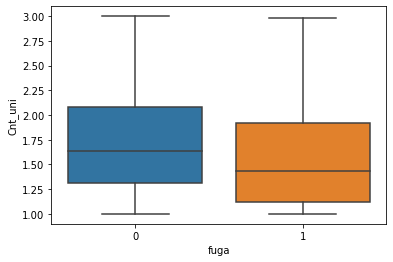

In [73]:
sns.boxplot(x='fuga',y='Cnt_uni',data=ventas_cliente[ventas_cliente['Cnt_uni']<3])

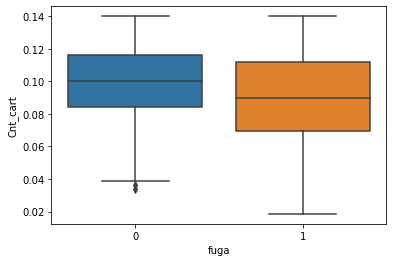

In [74]:
sns.boxplot(x='fuga',y='Cnt_cart',data=ventas_cliente[ventas_cliente['Cnt_cart']<.14])

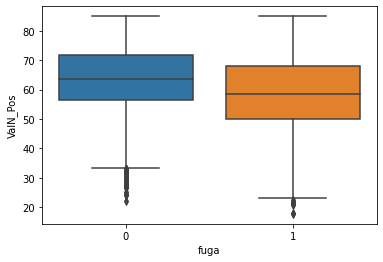

In [75]:
sns.boxplot(x='fuga',y='ValN_Pos',data=ventas_cliente[ventas_cliente['ValN_Pos']<85])

Existe una notable diferencia entre los valores de los clientes fugados y no fugados, esto nos da un buen indicio de que las variables pueden ser utiles para modelar, sin embargo es importante realizar algunos test de relacion y correlación antes de empezar el entranamiento de modelos.

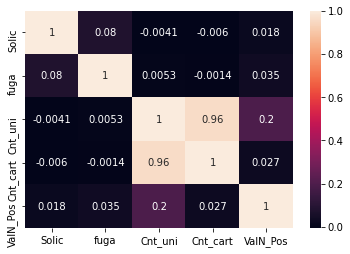

In [76]:
correlacion=ventas_cliente.corr()

sns.heatmap(correlacion,xticklabels=correlacion.columns,yticklabels=correlacion.columns,
           annot=True)

Nos interesa la relación existente entre las variables predictoras o dependientes y la variable de respuesta (fuga), podemos ver poca correlación en la mayoria de los casos.

### Primer ejercicio de entrenamiento

Utilizaremos una partición de 70-30 para la selección del grupo de entrenamiento y test, probaremos como se ajustan los datos a tres modelos de ML (regresión logística, random forest y KNN) para clasificación y veremos las metricas de evaluación para el mejor modelo de los tres que se probarán.

In [77]:
y = ventas_cliente['fuga']
X = ventas_cliente.drop(['fuga'], axis=1)

# mdt['y'].value_counts().plot('bar')

seed = 123
test_size = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = test_size, 
                                                    random_state = seed)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(56205, 4)
(24089, 4)
(56205,)
(24089,)


In [78]:
pipe = Pipeline([#('scaler', StandardScaler()),
                 ('selector', SelectKBest(mutual_info_classif, k='all')),
                 ('classifier', LogisticRegression())])

In [79]:
search_space = [
#                 {'selector__k': [10, 15, 20, 30]},
                {'classifier': [LogisticRegression(solver='lbfgs')],
                 'classifier__C': [0.01, 0.1, 1.0]},
                {'classifier': [RandomForestClassifier(n_estimators=20)],
                 'classifier__max_depth': [5, 10, None]},
                {'classifier': [KNeighborsClassifier()],
                 'classifier__n_neighbors': [2,3],
                 'classifier__weights': ['uniform', 'distance']}]

In [80]:
start = time.time()

# kappa_scorer = make_scorer(cohen_kappa_score, weights="quadratic")
#scorer = {"AUC": "roc_auc", 
#         "Accuracy": make_scorer(accuracy_score)}

clf = GridSearchCV(pipe, 
                   search_space, 
                   cv=5, 
                   verbose=0, 
                  # scoring = scorer,
                   #refit="AUC",
                   #return_train_score=True
                  )

clf = clf.fit(X_train, y_train)

end = time.time()
tiempo = (end-start)/60
print("Elapsed time: %0.10f min." % tiempo)

Elapsed time: 4.0667976101 min.


In [81]:
clf.best_estimator_

Pipeline(steps=[('selector',
                 SelectKBest(k='all',
                             score_func=<function mutual_info_classif at 0x0000029E4E811F70>)),
                ('classifier',
                 RandomForestClassifier(max_depth=10, n_estimators=20))])

In [82]:
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)
print(confusion_matrix(y_test, y_pred))

print("Precision = {}".format(precision_score(y_test,y_pred, average='weighted')))
print("Recall = {}".format(recall_score(y_test,y_pred, average='weighted')))
print("Accuracy Balanced = {}".format(balanced_accuracy_score(y_test, y_pred)))
print('\n')
print("-----Métricas Modelo ----")
print(classification_report(y_test,y_pred))
print('\n')
print("-----Kappa----")
print(cohen_kappa_score(y_test,y_pred))

[[20822   185]
 [ 2575   507]]
Precision = 0.8698198668517995
Recall = 0.8854248827265557
Accuracy Balanced = 0.577848490415435


-----Métricas Modelo ----
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     21007
           1       0.73      0.16      0.27      3082

    accuracy                           0.89     24089
   macro avg       0.81      0.58      0.60     24089
weighted avg       0.87      0.89      0.85     24089



-----Kappa----
0.2326785471220626


En este primer ejercicio podemos ver que utilizando las tres variables 'Cnt_uni', 'Cnt_cart' y 'ValN_Pos' el mejor modelo resulta ser un Random Forest. 

Observando las metricas de evaluación mediante la matriz de confunción calculada podemos ver que el modelo esta entendiendo muy bien la clase 0 (clasicación de un cliente como no fugado) y la clase 1 (clientes clasificados como fugas) presenta muchos problemas de falsos negativos, es decir, tenemos muchos clientes que el modelo clasifica como que no serán fugas, cuando realmente son clientes fugados, esto genera que el recall de los clientes fugados este dando del 16%. 

La presición de la clasificación de los clientes fugados es del 72% que resulta ser interesante, en este caso los falsos positivos son menores, entonces el modelo se esta equivocando menos cuando dice que un cliente se fugara y realmente no se fuga. 

Es importante definir que error es más grave en la practica, si queremos permitir más errores clasificando un cliente como no fugado cuando realmente se va a fugar o si queremos permitir más errores clasificando un cliente como fugado cuando realmente este no se va a fugar.

Se puede pensar que es más grave clasificar un cliente como que no se va a fugar cuando realmente se fuga ya que estariamos restandole atención a un cliente que posiblemente se pueda ir, sin embargo no podemos dejar de la lado que clasifiquemos a un cliente como fugado y este realmente no se valla, donde gastariamos recursos reteniendo clientes fieles.

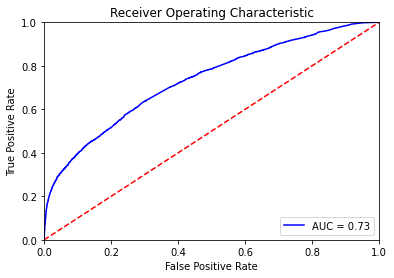

In [83]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
# probs = model.predict_proba(X_test)
preds = y_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Best Threshold=0.120026, G-Mean=0.668


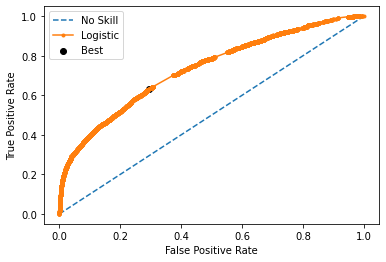

In [84]:
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (threshold[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

La curva ROC asociada al modelo resulta ser del 73%, un porcentaje aceptable, sin embargo tenemos algunos problemas en temas de recall y presición.

Se puede ver cual es el punto de corte optimo para clasificar un cliente como fugado o no  y de esta forma empezar a jugar con dicho punto de corte y restarle errores de falsos positivos o falsos negativos a la clasificación.

In [85]:
optimal_threshold=0.1254
y_pred2 = np.where((y_prob[:,1] > optimal_threshold), 1, 0)
y_pred2

array([1, 1, 0, ..., 0, 0, 1])

In [86]:
# y_prob = xgb_model.predict_proba(X)
print(confusion_matrix(y_test, y_pred2))



print("Precision = {}".format(precision_score(y_test,y_pred2, average='weighted')))
print("Recall = {}".format(recall_score(y_test,y_pred2, average='weighted')))
print("Accuracy Balanced = {}".format(balanced_accuracy_score(y_test, y_pred2)))
print('\n')
print("-----Métricas Modelo ----")
print(classification_report(y_test,y_pred2))
print('\n')
print("-----Kappa----")
print(cohen_kappa_score(y_test,y_pred2))

[[15713  5294]
 [ 1279  1803]]
Precision = 0.838921220547063
Recall = 0.7271368674498734
Accuracy Balanced = 0.666499249794273


-----Métricas Modelo ----
              precision    recall  f1-score   support

           0       0.92      0.75      0.83     21007
           1       0.25      0.59      0.35      3082

    accuracy                           0.73     24089
   macro avg       0.59      0.67      0.59     24089
weighted avg       0.84      0.73      0.77     24089



-----Kappa----
0.21403691663266877


Modificando el punto de corte (threshold) aumentamos el recall, pero se disminuye la presicion, este será el costo de tener menores falsos positivos o falsos negativos. En este caso el punto de corte optimo es de aproximadamente el 13% que es muy cercano al baseline que es el 12% (porcentaje de clientes fugados en la base).

### Segundo ejercicio de entrenamiento

Probaremos como influye en la clasificación balancear la base, realizando un ejercicio de undersampling que se basa en extraer una muestra de la clase mayoritaria (no fuga) para intentar disminuir esta clase y que la diferencia con los clientes fugados sea menor.

In [87]:
ceros = ventas_cliente[ventas_cliente['fuga'] == 0]
unos = ventas_cliente[ventas_cliente['fuga'] == 1]

print(ceros.shape)
print(unos.shape)

(69943, 5)
(10351, 5)


In [88]:
ceros = ceros[ceros['fuga'] == 0].sample(n=round(ceros.shape[0]*0.2), random_state=1)
ceros.shape

(13989, 5)

In [89]:
data_balance = pd.concat([ceros, unos])
data_balance.shape

(24340, 5)

In [90]:
data_balance['fuga'].value_counts(normalize=True)

0   0.575
1   0.425
Name: fuga, dtype: float64

In [91]:
y_under = data_balance['fuga']
X_under = data_balance.drop(['fuga'], axis=1)

# mdt['y'].value_counts().plot('bar')

seed = 123
test_size = 0.3

X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under, y_under, 
                                                                            test_size = test_size, 
                                                                            random_state = seed)

print(X_train_under.shape)
print(X_test_under.shape)
print(y_train_under.shape)
print(y_test_under.shape)

(17038, 4)
(7302, 4)
(17038,)
(7302,)


In [92]:
start = time.time()

# kappa_scorer = make_scorer(cohen_kappa_score, weights="quadratic")
#scorer = {"AUC": "roc_auc", 
#         "Accuracy": make_scorer(accuracy_score)}

clf2 = GridSearchCV(pipe, 
                   search_space, 
                   cv=5, 
                   verbose=0, 
                  # scoring = scorer,
                   #refit="AUC",
                   #return_train_score=True
                  )

clf2 = clf2.fit(X_train_under, y_train_under)

end = time.time()
tiempo = (end-start)/60
print("Elapsed time: %0.10f min." % tiempo)

Elapsed time: 0.9081871549 min.


In [93]:
clf2.best_estimator_

Pipeline(steps=[('selector',
                 SelectKBest(k='all',
                             score_func=<function mutual_info_classif at 0x0000029E4E811F70>)),
                ('classifier',
                 RandomForestClassifier(max_depth=10, n_estimators=20))])

In [94]:
y_pred2 = clf2.predict(X_test_under)
y_prob2 = clf2.predict_proba(X_test_under)
print(confusion_matrix(y_test_under, y_pred2))

print("Precision = {}".format(precision_score(y_test_under,y_pred2, average='weighted')))
print("Recall = {}".format(recall_score(y_test_under,y_pred2, average='weighted')))
print("Accuracy Balanced = {}".format(balanced_accuracy_score(y_test_under, y_pred2)))
print('\n')
print("-----Métricas Modelo ----")
print(classification_report(y_test_under,y_pred2))
print('\n')
print("-----Kappa----")
print(cohen_kappa_score(y_test_under,y_pred2))

[[3637  517]
 [1839 1309]]
Precision = 0.6868891849879337
Recall = 0.6773486715968228
Accuracy Balanced = 0.6456806072926754


-----Métricas Modelo ----
              precision    recall  f1-score   support

           0       0.66      0.88      0.76      4154
           1       0.72      0.42      0.53      3148

    accuracy                           0.68      7302
   macro avg       0.69      0.65      0.64      7302
weighted avg       0.69      0.68      0.66      7302



-----Kappa----
0.3069709485131358


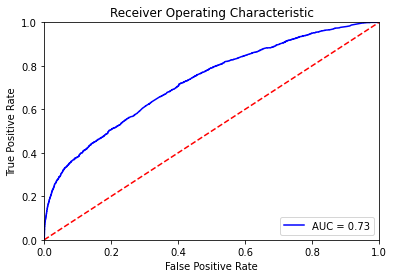

In [95]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
# probs = model.predict_proba(X_test)
preds = y_prob2[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test_under, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Best Threshold=0.412139, G-Mean=0.657


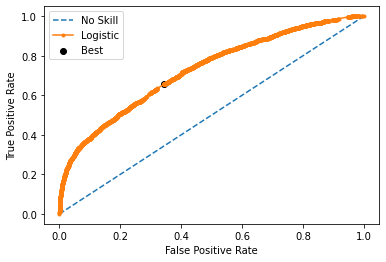

In [96]:
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (threshold[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [102]:
optimal_threshold=0.41
y_pred3 = np.where((y_prob2[:,1] > optimal_threshold), 1, 0)
y_pred3

array([1, 0, 0, ..., 1, 0, 0])

In [103]:
# y_prob = xgb_model.predict_proba(X)
print(confusion_matrix(y_test_under, y_pred3))



print("Precision = {}".format(precision_score(y_test_under,y_pred3, average='weighted')))
print("Recall = {}".format(recall_score(y_test_under,y_pred3, average='weighted')))
print("Accuracy Balanced = {}".format(balanced_accuracy_score(y_test_under, y_pred3)))
print('\n')
print("-----Métricas Modelo ----")
print(classification_report(y_test_under,y_pred3))
print('\n')
print("-----Kappa----")
print(cohen_kappa_score(y_test_under,y_pred3))

[[2697 1457]
 [1067 2081]]
Precision = 0.6611958953160753
Recall = 0.6543412763626404
Accuracy Balanced = 0.6551541846042974


-----Métricas Modelo ----
              precision    recall  f1-score   support

           0       0.72      0.65      0.68      4154
           1       0.59      0.66      0.62      3148

    accuracy                           0.65      7302
   macro avg       0.65      0.66      0.65      7302
weighted avg       0.66      0.65      0.66      7302



-----Kappa----
0.30572211387330117


Despues de realizar varias iteraciones modificando la proporción de clientes no fugados para balancear la base, tenemos un modelo con resultados con una mejora con respecto al primer ejercicio de entrenamiento, sin embargo es posible encontrar mejores resultados.

Se recomienda:

* Evaluar algunas de las recomendaciones realizadas con respecto a las variables que se puedan crear en función de la temporalidad, los sectores de los productos o los distintos productos que solicitan los cliente.

* Evaluar la posibilidad de nutrir la información de clientes fugados para no depender de una metodologia adicional para balancear la base

* Probar nuevas metodologias de balance de la base

* Probar algoritmos que traten o generen pesos sobre las clases minoritarias de manera que se sobrelleve el desbalance de la base.


### Predicción 

In [99]:
y_pred_final = clf2.predict(X)
len(y_pred_final)

80294

In [100]:
ventas_cliente['predicción'] = y_pred_final
ventas_cliente.head()

,Solic,fuga,Cnt_uni,Cnt_cart,ValN_Pos,predicción
0,49128,0,4.931,0.693,304.072,0
1,69792,0,2.579,0.108,66.117,0
2,69838,0,6.824,0.317,138.823,0
3,69868,0,3.247,0.109,74.253,0
4,70334,0,2.149,0.193,136.520,0


In [101]:
ventas_cliente['predicción'].value_counts()

0    67545
1    12749
Name: predicción, dtype: int64

In [104]:
ventas_cliente['Solic'].value_counts()

18175608    1
18127262    1
18122368    1
18082880    1
1055574     1
           ..
18118164    1
18130238    1
18172528    1
1135936     1
1310720     1
Name: Solic, Length: 80294, dtype: int64

In [105]:
file_export = ventas_cliente[['Solic', 'predicción']]
file_export = file_export.rename(columns = {'Solic':'clientes'})
file_export.head()

,clientes,predicción
0,49128,0
1,69792,0
2,69838,0
3,69868,0
4,70334,0


In [106]:
file_export.to_csv('prediccion.txt', index = False)